<a href="https://colab.research.google.com/github/Sobhan-Gh/Graph-state-functions/blob/main/row_reduced_echelon_form.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# sum initialization for test (complete graph)
n = 5
x = np.eye(n)
z = np.ones([n, n]) - np.eye(n)
r = np.zeros([n,1]) #phase: r_i = 1 if the i-th generator has negative phase and 0 otherwise. 

In [3]:
# import from .../src/backends/stabilizer/functions.py
def row_swap(input_matrix, first_row, second_row):

    input_matrix[[first_row, second_row]] = input_matrix[[second_row, first_row]]
    return input_matrix


def add_rows(input_matrix, row_to_add, resulting_row):

    input_matrix[resulting_row] = (input_matrix[row_to_add] + input_matrix[resulting_row]) % 2
    return input_matrix

def symplectic_to_string(x_matrix, z_matrix):
    """
    Convert a binary symplectic representation to a list of strings
    :param x_matrix: X part of the binary symplectic representation
    :param z_matrix: Z part of the binary symplectic representation
    :return: a list of strings that represent stabilizer generators
    :rtype: list[str]
    """
    assert x_matrix.shape == z_matrix.shape
    n_row, n_column = x_matrix.shape
    generator_list = []
    for i in range(n_row):
        generator = ''
        for j in range(n_column):
            if x_matrix[i, j] == 1 and z_matrix[i, j] == 0:
                generator = generator + 'X'
            elif x_matrix[i, j] == 1 and z_matrix[i, j] == 1:
                generator = generator + 'Y'
            elif x_matrix[i, j] == 0 and z_matrix[i, j] == 1:
                generator = generator + 'Z'
            else:
                generator = generator + 'I'
        generator_list.append(generator)
    return generator_list

In [4]:
def g_function(x_1, z_1, x_2, z_2): #refer to section III of arXiv:quant-ph/0406196v5
    ''' a helper function to use in rowsum function. 
    takse 4 bit (2 pauli matrices in binary representation) as input and returns
    the phase factor needed when the two Pauli matrices are multiplied.'''  
    if not (x_1 or z_1): #both equal to zero
        return 0
    if x_1 and z_1:
        return (z_2 - x_2)%4
    if x_1 == 1 and z_1 == 0:
        return (z_2*(2*x_2-1))%4
    if x_1 == 0 and z_1 == 1:
        return (x_2*(1-2*z_2))%4    

In [5]:
def rowsum(x_matrix, z_matrix, r_vector, i, h): #refer to section III of arXiv:quant-ph/0406196v5
    '''takes the full stabilizer tableau as input and sets the generator in row h
      equal to i+h and also keeps track of the phase'''
    n = np.shape(x_matrix)[0]
    # determining the phase factor
    g_sum = 0 
    for j in range(n):
        g_sum = g_sum + g_function(x_matrix[i, j], z_matrix[i, j], x_matrix[h, j], z_matrix[h, j])
    if (2*r_vector[h, 0] + 2*r_vector[i, 0] + g_sum)%4 == 0:
        r_vector[h, 0] = 0 
    elif (2*r_vector[h, 0] + 2*r_vector[i, 0] + g_sum)%4 == 2:
        r_vector[h, 0] = 1
    else:
        raise Exception('input cannot be valid, due to unexpected outcome')
    
    #calculating the resulting new matrices after adding row i to h. 
    x_matrix = add_rows(x_matrix, i, h)
    z_matrix = add_rows(z_matrix, i, h)

    return x_matrix, z_matrix, r_vector

In [6]:
def rowswap(x_matrix, z_matrix, r_vector, first_row, second_row):
    x_matrix = row_swap(x_matrix, first_row, second_row)
    z_matrix = row_swap(z_matrix, first_row, second_row)
    r_vector = row_swap(r_vector, first_row, second_row)
    return x_matrix, z_matrix, r_vector

In [7]:
def pauli_type_finder(x_matrix, z_matrix, pivot):
    '''a function that counts the types and the number of the pauli operators 
    acting on a pivot qubit (the pivot column in the stabilizer tableau) over 
    generators (rows) below the pivot element in the tableau'''
    number_of_qubits = np.shape(x_matrix)[0]
    pauli_x_list = [] #list of the rows (generators) with a pauli X operator in the pivot column
    pauli_y_list = [] #list of the rows (generators) with a pauli Y operator in the pivot column
    pauli_z_list = [] #list of the rows (generators) with a pauli Z operator in the pivot column

    for i in range(pivot[0], number_of_qubits):
        if x_matrix[i, pivot[1]] == 1 and z_matrix[i, pivot[1]] == 0:
            pauli_x_list.append(i)
        if x_matrix[i, pivot[1]] == 1 and z_matrix[i, pivot[1]] == 1:
            pauli_y_list.append(i)
        if x_matrix[i, pivot[1]] == 0 and z_matrix[i, pivot[1]] == 1:
            pauli_z_list.append(i)

    return pauli_x_list, pauli_y_list, pauli_z_list

In [8]:
def one_step_rref(x_matrix, z_matrix, r_vector, pivot): #ROW-REDUCED ECHELON FORM algorithm
    
    #pivot = [0, 0] #remove later! it is in the arguments

    #pauli_x_list = [] = list of the rows (generators) with a pauli X operator in the pivot column
    #pauli_y_list = [] = list of the rows (generators) with a pauli Y operator in the pivot column
    #pauli_z_list = [] = list of the rows (generators) with a pauli Z operator in the pivot column
    pauli_x_list, pauli_y_list, pauli_z_list = pauli_type_finder(x_matrix, z_matrix, pivot)

    #case of no pauli operator!
    if not (pauli_x_list or pauli_y_list or pauli_z_list):
        pivot = [pivot[0], pivot[1] + 1]
        return x_matrix, z_matrix, r_vector, pivot
    # case of only 1 kind of puali 
    elif pauli_x_list and (not pauli_y_list) and (not pauli_z_list): #only X
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0], pauli_x_list[0]) #swap the pivot row with it

        pauli_x_list = pauli_x_list[1:] #remove the first element of the list

        for row_i in pauli_x_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0], row_i) #multiplying rows with similar pauli to eleminate them

        pivot = [pivot[0] + 1, pivot[1] + 1]
        return x_matrix, z_matrix, r_vector, pivot

    elif pauli_y_list and (not pauli_x_list) and (not pauli_z_list): #only Y
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0], pauli_y_list[0]) #swap the pivot row with it

        pauli_y_list = pauli_y_list[1:] #remove the first element of the list

        for row_i in pauli_y_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0], row_i) #multiplying rows with similar pauli to eleminate them

        pivot = [pivot[0] + 1, pivot[1] + 1]
        return x_matrix, z_matrix, r_vector, pivot

    elif pauli_z_list and (not pauli_x_list) and (not pauli_y_list): #only Z
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0], pauli_z_list[0]) #swap the pivot row with it

        pauli_z_list = pauli_z_list[1:] #remove the first element of the list

        for row_i in pauli_z_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0], row_i) #multiplying rows with similar pauli to eleminate them

        pivot = [pivot[0] + 1, pivot[1] + 1]
        return x_matrix, z_matrix, r_vector, pivot
    #case of two kinds of pauli 
    elif not pauli_x_list: #pauli y and z exist in the column below pivot
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0], pauli_y_list[0]) #swap the pivot and its next row with them
        pauli_x_list, pauli_y_list, pauli_z_list = pauli_type_finder(x_matrix, z_matrix, pivot) #update pauli lists
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0]+1, pauli_z_list[0])
        pauli_x_list, pauli_y_list, pauli_z_list = pauli_type_finder(x_matrix, z_matrix, pivot) #update pauli lists

        assert pauli_y_list[0] == pivot[0] and pauli_z_list[0] == pivot[0]+1, "row operations failed" 

        pauli_y_list = pauli_y_list[1:] #remove the first element of the list
        pauli_z_list = pauli_z_list[1:] #remove the first element of the list

        for row_i in pauli_y_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0], row_i) #multiplying rows with similar pauli to eleminate them

        for row_j in pauli_z_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0]+1, row_j) #multiplying rows with similar pauli to eleminate them
        
        pivot = [pivot[0] + 2, pivot[1] + 1]
        return x_matrix, z_matrix, r_vector, pivot

    elif not pauli_y_list: #pauli x and z exist in the column below pivot
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0], pauli_x_list[0]) #swap the pivot and its next row with them
        pauli_x_list, pauli_y_list, pauli_z_list = pauli_type_finder(x_matrix, z_matrix, pivot) #update pauli lists
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0]+1, pauli_z_list[0])
        pauli_x_list, pauli_y_list, pauli_z_list = pauli_type_finder(x_matrix, z_matrix, pivot) #update pauli lists

        assert pauli_x_list[0] == pivot[0] and pauli_z_list[0] == pivot[0]+1, "row operations failed" 

        pauli_x_list = pauli_x_list[1:] #remove the first element of the list
        pauli_z_list = pauli_z_list[1:] #remove the first element of the list
        
        for row_i in pauli_x_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0], row_i) #multiplying rows with similar pauli to eleminate them

        for row_j in pauli_z_list: 
            #print(row_j)
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0]+1, row_j) #multiplying rows with similar pauli to eleminate them
        
        pivot = [pivot[0] + 2, pivot[1] + 1]
        return x_matrix, z_matrix, r_vector, pivot
      
    elif not pauli_z_list: #pauli x and y exist in the column below pivot
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0], pauli_x_list[0]) #swap the pivot and its next row with them
        pauli_x_list, pauli_y_list, pauli_z_list = pauli_type_finder(x_matrix, z_matrix, pivot) #update pauli lists
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0]+1, pauli_y_list[0])
        pauli_x_list, pauli_y_list, pauli_z_list = pauli_type_finder(x_matrix, z_matrix, pivot) #update pauli lists

        assert pauli_x_list[0] == pivot[0] and pauli_y_list[0] == pivot[0]+1, "row operations failed" 

        pauli_x_list = pauli_x_list[1:] #remove the first element of the list
        pauli_y_list = pauli_y_list[1:] #remove the first element of the list

        for row_i in pauli_x_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0], row_i) #multiplying rows with similar pauli to eleminate them

        for row_j in pauli_y_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0]+1, row_j) #multiplying rows with similar pauli to eleminate them
        
        pivot = [pivot[0] + 2, pivot[1] + 1]
        return x_matrix, z_matrix, r_vector, pivot

    #case of all three kinds of paulis available in the column
    else:
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0], pauli_x_list[0]) #swap the pivot and its next row with the first X and Z rows
        pauli_x_list, pauli_y_list, pauli_z_list = pauli_type_finder(x_matrix, z_matrix, pivot) #update pauli lists
        x_matrix, z_matrix, r_vector = rowswap(x_matrix, z_matrix, r_vector, pivot[0]+1, pauli_z_list[0])
        pauli_x_list, pauli_y_list, pauli_z_list = pauli_type_finder(x_matrix, z_matrix, pivot) #update pauli lists
        
        assert pauli_x_list[0] == pivot[0] and pauli_z_list[0] == pivot[0]+1, "row operations failed" 

        pauli_x_list = pauli_x_list[1:] #remove the first element of the list
        pauli_z_list = pauli_z_list[1:] #remove the first element of the list

        for row_i in pauli_x_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0], row_i) #multiplying rows with similar pauli to eleminate them

        for row_j in pauli_z_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0]+1, row_j) #multiplying rows with similar pauli to eleminate them
        
        for row_k in pauli_y_list: 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0], row_k) #multiplying the pauli Y with pauli X to make it Z 
            x_matrix, z_matrix, r_vector = rowsum(x_matrix, z_matrix, r_vector, pivot[0]+1, row_k) #multiplying the now Z row with another Z to eleminate it
        pivot = [pivot[0] + 2, pivot[1] + 1]
        return x_matrix, z_matrix, r_vector, pivot


In [9]:
def rref(x_matrix, z_matrix, r_vector):
    pivot = [0, 0]
    number_of_qubits = np.shape(x_matrix)[0]
    while pivot[0] <= number_of_qubits-1 and pivot[1] <= number_of_qubits-1:
        x_matrix, z_matrix, r_vector, pivot = one_step_rref(x_matrix, z_matrix, r_vector, pivot)
    return x_matrix, z_matrix, r_vector

In [11]:
rref(x, z, r)

(array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1.]]), array([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1.]]), array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [12]:
pauli_type_finder(x,z,[0,4])

([], [4], [0, 1])

In [19]:
def height_function(x_matrix, z_matrix, qubit_position):
    number_of_qubits = np.shape(x_matrix)[0]
    r_vector = np.zeros([number_of_qubits,1])
    non_trivial_generators = 0
    height = 0

    x_matrix, z_matrix, r_vector = rref(x_matrix, z_matrix, r_vector)

    left_most_nontrivial=[]
    for i in range(n):
        for j in range(n):
            if not(x_matrix[i, j] == 0 and z_matrix[i, j] == 0):
                left_most_nontrivial.append(j)
                break
    assert len(left_most_nontrivial) == n,"None entangled qubits is found!"
    number_of_non_trivial_generators = len([x-qubit_position for x in left_most_nontrivial if x-qubit_position > 0])


#    for i in range(number_of_qubits-1, -1, -1):
#        if not(x_matrix[i, qubit_position] == 0 and z_matrix[i, qubit_position] == 0): #first place where there is not an identity operator in the column when coming up from the last row
#            non_trivial_generators = number_of_qubits - (i+1)
#            break
    height = number_of_qubits - (qubit_position+1) - number_of_non_trivial_generators
    return height

In [14]:
def edge_list_finder(G):
    if isinstance(G, nx.classes.graph.Graph): 
        pass
    if isinstance(G, np.ndarray):
        G = nx.to_networkx_graph(G)
    edge_list1 = []
    for line in nx.generate_edgelist(G, data=False):
         a = (str(int(line[0])+1),', ',str(int(line[2])+1),'; ') # the plus +1 part make it compatible with matlab indexing node for graphs, node 0 in python = node 1 in sophia's matlab code
         edge_list1.append(''.join(list(a)))
    b = ''.join(edge_list1)
    b = b[:-2] #delete the last semicolon
    return b


Edge_List 1, 2; 1, 5; 1, 6; 1, 7; 2, 4; 2, 6; 3, 5; 3, 7; 4, 5; 4, 7; 5, 6; 5, 7; 6, 7


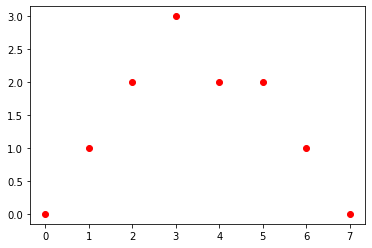

In [37]:
from networkx.convert_matrix import to_numpy_array
n=7
G1 = nx.gnp_random_graph(n, 0.7)
height_x = [0]
positions = [0]
if nx.is_connected(G1):
    z = nx.to_numpy_array(G1)
    x = np.eye(n)
    for i in range(n):
        height_x.append(height_function(x, z, i))
        positions.append(i+1)

print('Edge_List',edge_list_finder(G1))   
     
#nx.draw(G1,with_labels =True)
plt.plot(positions, height_x, 'ro')
plt.show()

In [39]:
a = symplectic_to_string(x, z)
a = np.asarray(a)
a.reshape([n,1])

array([['XZIIZZZ'],
       ['ZXIZIZI'],
       ['IXZIXIZ'],
       ['IZIXZIZ'],
       ['IIXIZIZ'],
       ['IIZYXYZ'],
       ['IIIIYIY']], dtype='<U7')